In [139]:
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="D:\\6_sem\\bigdata\\esoteric-bruin-379522-1ac227ab6db1.json"
client = bigquery.Client()

pd.set_option('display.max_columns', None)

In [259]:
# 1.1 Przygotuj dane, które będą Ci potrzebne do przewidzenia nowych przypadków COVID-19 i przefiltruj je, 
# aby uwzględnić tylko interesujący Cię okres czasu (np.rok 2022, I i II kw. 2021).
sql = """
    select
    new_confirmed, date, new_deceased, new_persons_vaccinated
    from `bigquery-public-data.covid19_open_data.covid19_open_data`
    where aggregation_level = 0
    and country_name = 'Poland'
    and date between '2021-09-01' and '2022-03-01'
    order by date
"""
q1 = (sql)
query_job = client.query(q1)
query_result = query_job.result()
df = query_result.to_dataframe()
df

,new_confirmed,date,new_deceased,new_persons_vaccinated
0,390,2021-09-01,7,22597
1,349,2021-09-02,5,24677
2,389,2021-09-03,7,29381
3,324,2021-09-04,0,18897
4,183,2021-09-05,0,11528
...,...,...,...,...
177,8902,2022-02-25,221,6344
178,6564,2022-02-26,40,3290
179,12984,2022-02-27,1,463
180,14737,2022-02-28,269,3281


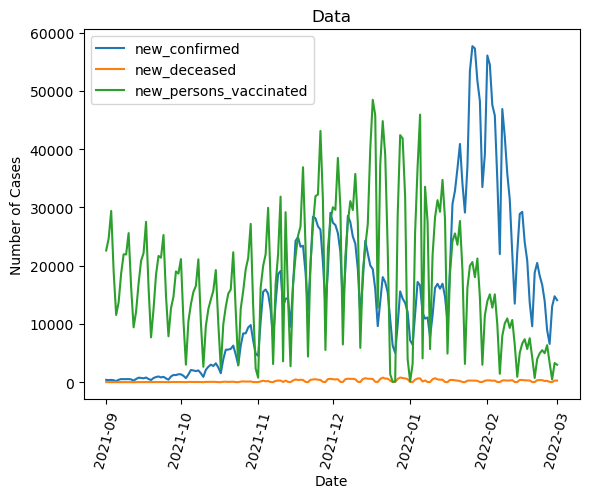

In [260]:
#Przedstawienie na wykresie pobranych danych
plt.plot(df['date'], df['new_confirmed'], label ='new_confirmed')
plt.plot(df['date'], df['new_deceased'], label ='new_deceased')
plt.plot(df['date'], df['new_persons_vaccinated'], label ='new_persons_vaccinated')
plt.xticks(rotation=75)
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Data')
plt.legend(loc = 2)
plt.show()

In [261]:
#1.2 przygotowanie do analizy regresji liniowej
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime as dt
df['date'] = pd.to_datetime(df['date'])
df['date']=df['date'].map(dt.datetime.toordinal)
lr= LinearRegression()
lr.fit(df[['date']].values.reshape(-1,1),df[['new_confirmed']])


LinearRegression()

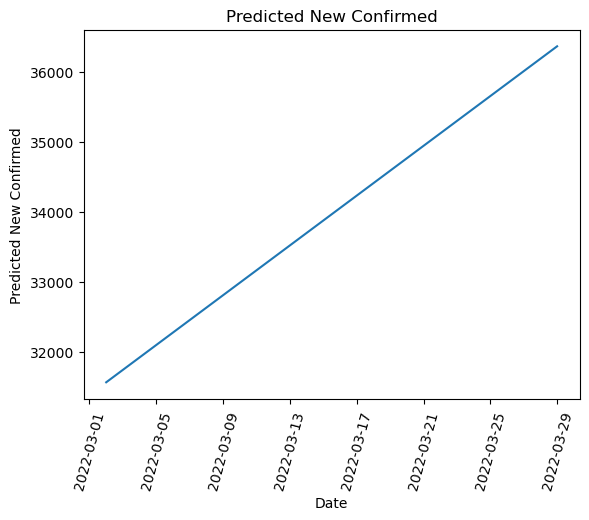

,date,predicted_new_confrimed
0,2022-03-02,31561.680529
1,2022-03-03,31739.568949
2,2022-03-04,31917.457369
3,2022-03-05,32095.345789
4,2022-03-06,32273.234209
5,2022-03-07,32451.122629
6,2022-03-08,32629.011049
7,2022-03-09,32806.899469
8,2022-03-10,32984.787889
9,2022-03-11,33162.676308


In [262]:
# Zastosowanie analizy regresji, aby przewidzieć liczbę nowych przypadków w kolejnych tygodniach
predicted_data = pd.DataFrame({'date':pd.date_range('2022-03-02', periods=28)})
predicted_data['date'] = pd.to_datetime(predicted_data['date'])
predicted_data['date']=predicted_data['date'].map(dt.datetime.toordinal)
pred = lr.predict(predicted_data['date'].values.reshape(-1,1))
predicted_data['predicted_new_confrimed'] = pred
predicted_data['date']=predicted_data['date'].map(dt.datetime.fromordinal)


plt.plot(predicted_data['date'], predicted_data['predicted_new_confrimed'])
plt.xticks(rotation=75)
plt.xlabel('Date')
plt.ylabel('Predicted New Confirmed')
plt.title('Predicted New Confirmed')
plt.show()
predicted_data

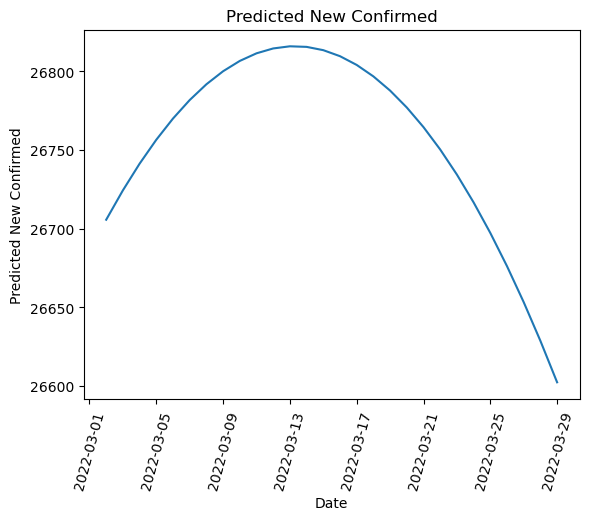

,date,predicted_new_confrimed,predicted_poly_new_confrimed
0,2022-03-02,31561.680529,26705.745880
1,2022-03-03,31739.568949,26724.420258
2,2022-03-04,31917.457369,26741.363739
3,2022-03-05,32095.345789,26756.576508
4,2022-03-06,32273.234209,26770.058380
5,2022-03-07,32451.122629,26781.809418
6,2022-03-08,32629.011049,26791.829620
7,2022-03-09,32806.899469,26800.118988
8,2022-03-10,32984.787889,26806.677460
9,2022-03-11,33162.676308,26811.505157


In [263]:
#1.3 Użyj regresji wielomianowej jako rozszerzenia regresji liniowej, który pozwala na modelowanie związku pomiędzy zmiennymi
# niezależnymi, a zmienną zależną za pomocą wielomianu. W regresji wielomianowej zastosowanie wielomianów wyższych stopni
# pozwala na uwzględnienie nieliniowych związków między zmiennymi niezależnymi (np. czasem) a zmienną zależną  (np. liczbą 
# nowych przypadków). Aby dobrać odpowiedni stopień wielomianu, można przeprowadzić walidację krzyżową lub podzielić dane
# na zbiory treningowe i testowe, a następnie obliczyć metryki błędów dla różnych stopni wielomianów. Weź pod uwagę, że na
# liczbę nowych przypadków mogą wpływać inne czynniki takie jak np.: polityka rządowa (ograniczenia społeczne, noszenie
# maseczek), gęstość zaludnienia, dostęp do opieki zdrowotnej, struktura demograficzna, itd.
from sklearn.preprocessing import PolynomialFeatures

predicted_data['date']=predicted_data['date'].map(dt.datetime.toordinal)
pr = PolynomialFeatures(degree = 3, include_bias=False)
X_poly = pr.fit_transform(df['date'].values.reshape(-1,1))
lr2= LinearRegression()
lr2.fit(X_poly,df[['new_confirmed']]) 

pred2 = lr2.predict(pr.fit_transform(predicted_data[['date']]))
predicted_data['predicted_poly_new_confrimed'] = pred2
predicted_data['date']=predicted_data['date'].map(dt.datetime.fromordinal)
df['date']=df['date'].map(dt.datetime.fromordinal)

plt.plot(predicted_data['date'], predicted_data['predicted_poly_new_confrimed'])
plt.xticks(rotation=75)
plt.xlabel('Date')
plt.ylabel('Predicted New Confirmed')
plt.title('Predicted New Confirmed')
plt.show()

predicted_data

Text(0.5, 1.0, 'Regresion comparison')

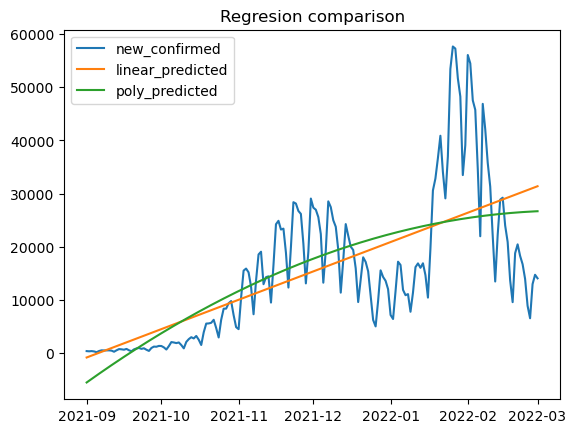

In [264]:
# Porównanie regresji liniowej i wielomianowej do ilości nowych przypadków.
df['date']=df['date'].map(dt.datetime.toordinal)
linear_predicted = lr.predict(df['date'].values.reshape(-1,1))
poly_predicted = lr2.predict(pr.fit_transform(df[['date']]))
df['date']=df['date'].map(dt.datetime.fromordinal)
plt.plot(df['date'], df['new_confirmed'], label ='new_confirmed')
plt.plot(df['date'], linear_predicted, label ='linear_predicted')
plt.plot(df['date'], poly_predicted, label ='poly_predicted')
plt.legend(loc = 2)
plt.title("Regresion comparison")

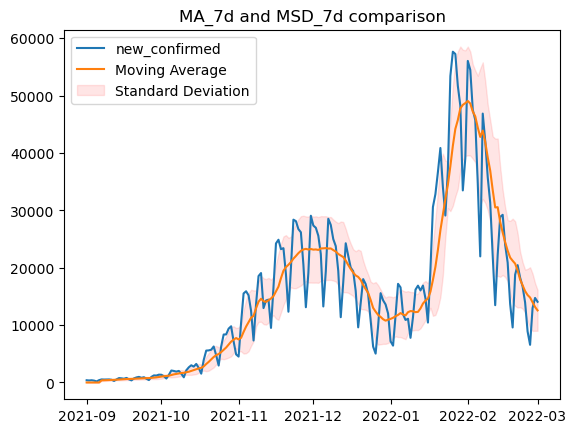

In [265]:
#2.1  Przeanalizuj trendy i zmiany w czasie dotyczące liczby nowych przypadków COVID-19.
#Spróbuj wyznaczyć średnią kroczącą i odchylenie standardowe kroczące (np. 7-dniowe), 
#dla tych zmiennych, aby zobaczyć, jak zjawiska te zmieniają się w czasie.
#Sprawdź, czy występują jakieś sezonowe wzorce lub cykle.

from statsmodels.tsa.seasonal import seasonal_decompose

#Średnia krocząca 7-dniowa
df['Moving_Average'] = df['new_confirmed'].rolling(7).mean()

#Odchylenie standardowe kroczace 7-dniowe
df['Moving_Standart_Deviation'] = df['new_confirmed'].rolling(7).std()

df[["Moving_Average","Moving_Standart_Deviation"]] = df[["Moving_Average","Moving_Standart_Deviation"]].fillna(0)

plt.plot(df['date'], df['new_confirmed'], label ='new_confirmed')
plt.plot(df['date'], df['Moving_Average'], label ='Moving Average')
#plt.plot(df['date'], df['MSD_7d'], label ='MSD_7d')
plt.fill_between(df['date'], df['Moving_Average'] - df['Moving_Standart_Deviation'], df['Moving_Average'] + df['Moving_Standart_Deviation'], alpha=0.1, color ="red",  label='Standard Deviation')
plt.legend(loc = 2)
plt.title("MA_7d and MSD_7d comparison")
plt.show()

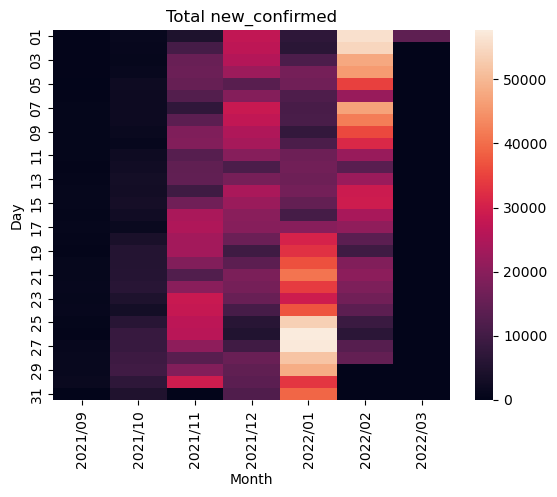

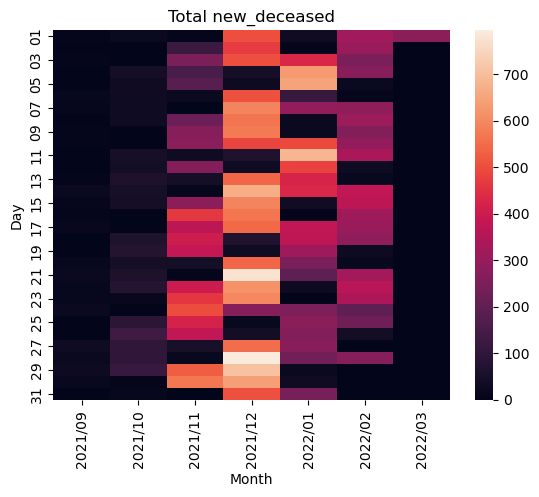

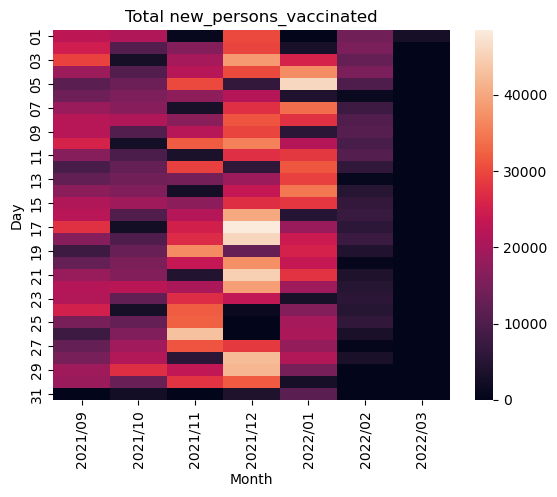

In [270]:
# Heatmapa dla rozłożenia ilości przyapdków w czasie
import seaborn as sns
df['Year_Month'] = df['date'].dt.strftime('%Y/%m')
df['Day'] = df['date'].dt.strftime('%d')
df
tmp = df.pivot_table(index="Day", columns="Year_Month", values="new_confirmed")
tmp = tmp.fillna(0)
tmp = tmp.astype(float)
sns.heatmap(tmp)
plt.title("Total new_confirmed")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()

tmp = df.pivot_table(index="Day", columns="Year_Month", values="new_deceased")
tmp = tmp.fillna(0)
tmp = tmp.astype(float)
sns.heatmap(tmp)
plt.title("Total new_deceased")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()

tmp = df.pivot_table(index="Day", columns="Year_Month", values="new_persons_vaccinated")
tmp = tmp.fillna(0)
tmp = tmp.astype(float)
sns.heatmap(tmp)
plt.title("Total new_persons_vaccinated")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()

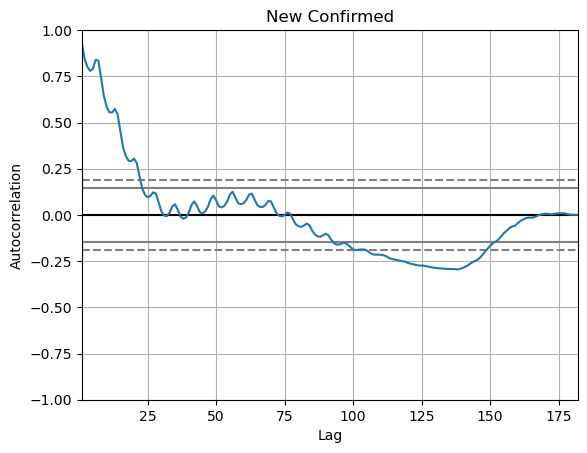

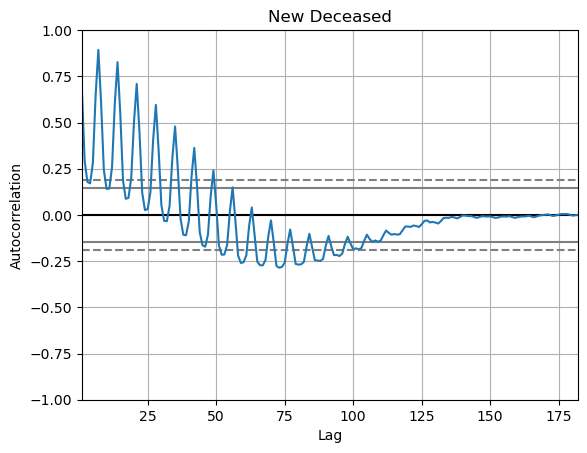

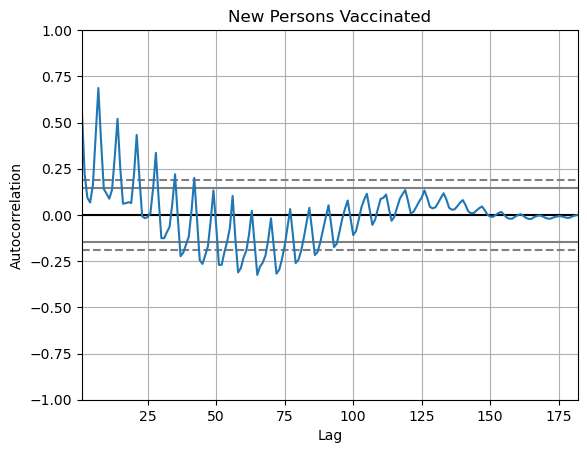

In [267]:
#2.2. Wykorzystaj do analizy trendów analizę szeregów czasowych (autoregresja, średnia ruchoma, modele autoregresyjne), 
#która umożliwi zbadanie danych zebranych w Twoich bazach w danym okresie czasu.
import seaborn as sns
# Wykres przedstawiający autokorelacje w całym okresie
# Autokorelacja informuje nas o tym na ile dane wartości / obserwacje są istotnie związane z obserwacjami
# zaobserwowanymi wcześniej (o stałym przesunięciu czasowym).
x = pd.plotting.autocorrelation_plot(df['new_confirmed'])
x.plot()
plt.title("New Confirmed")
plt.show()

x = pd.plotting.autocorrelation_plot(df['new_deceased'])
x.plot()
plt.title("New Deceased")
plt.show()

x = pd.plotting.autocorrelation_plot(df['new_persons_vaccinated'])
x.plot()
plt.title("New Persons Vaccinated")
plt.show()

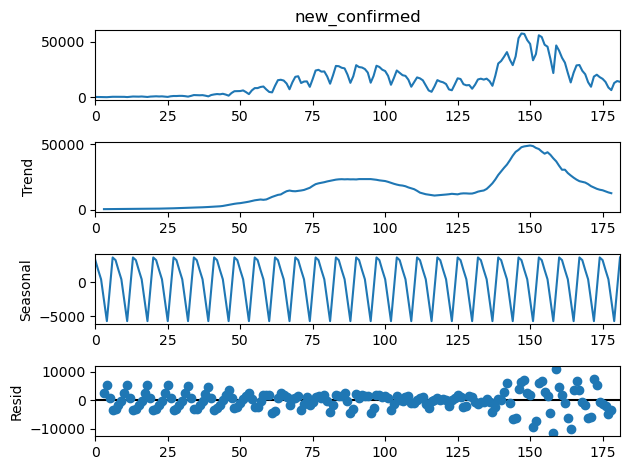

TypeError: 'NoneType' object is not callable

In [271]:
# Trend: Rosnąca lub malejąca wartość w szeregu. Jeśli linia trendu jest płaska lub oscyluje wokół pewnej wartości,
# oznacza to brak wyraźnego trendu
# Seasonality: Powtarzający się cykl krótkoterminowy w serii.
# Resid: Losowa zmienność w szeregu. Residual to to, co pozostaje po usunięciu trendu i sezonowości. Na przykład może
# istnieć pewien wzorzec autokorelacji szybko ewoluujący wokół wolno poruszającego się trendu oraz sezonowych wahań.
# Tego rodzaju wzorca nie można przypisać składnikowi trendu (ten pierwszy porusza się zbyt szybko) ani składnikowi sezonowemu
#(ten pierwszy nie przestrzega sezonowego harmonogramu). Zostaje więc w residual. 
decompose = seasonal_decompose(df['new_confirmed'],model='additive', period=7)
decompose.plot()
plt.show()(df['new_confirmed'],model='additive', period=7)
decompose.plot()
plt.show()

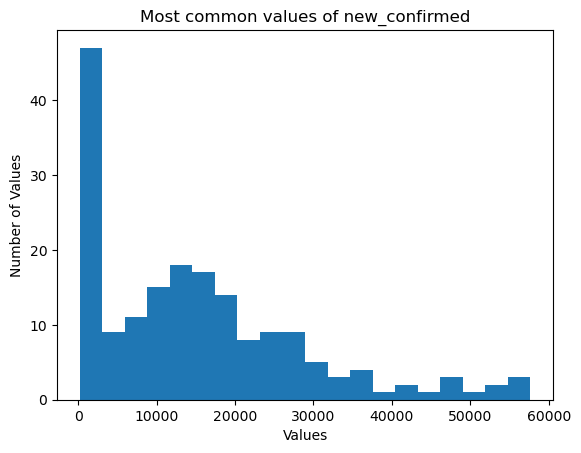

In [272]:
#Wykres rozłożenia wartosci new_confirmed
plt.hist(df['new_confirmed'], 20, histtype='bar')
plt.title("Most common values of new_confirmed")
plt.xlabel("Values")
plt.ylabel("Number of Occurrences of the Value")
plt.show()


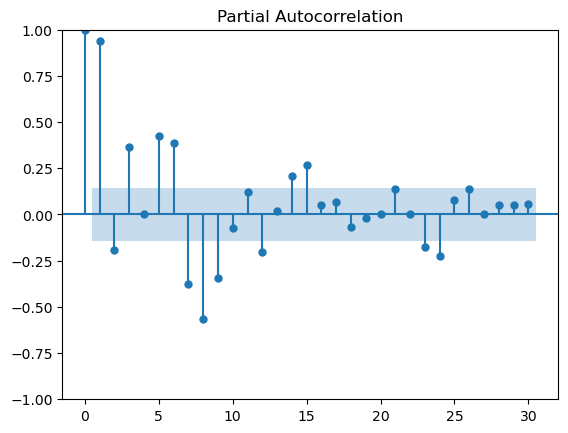

In [138]:
# Poniższy wykres może posłużyć do określenia dla jakiej wartości lags użyć autoregresji.
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df['new_confirmed'], lags=30)

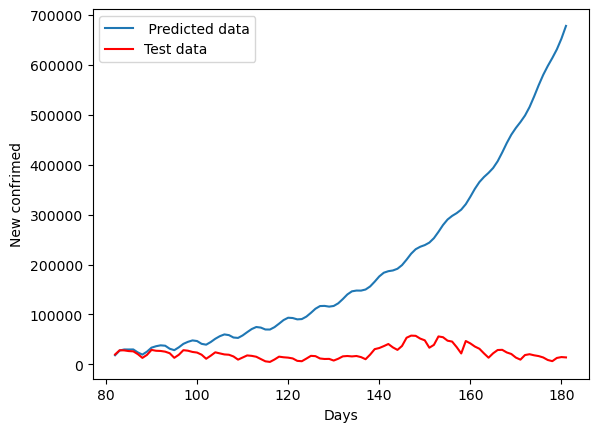

In [136]:
# Model autoregresyjny to model szeregów czasowych, który opisuje, w jaki sposób przeszłe wartości danej zmiennej wpływają 
# na jej aktualną wartość. Autoregresja czyli liniowa regresja która wykonuje się na sobie.
from statsmodels.tsa.ar_model import AutoReg
train_data = df['new_confirmed'][:len(df)-100]
test_data = df['new_confirmed'][len(df)-100:]

ar_model = AutoReg(train_data.astype(float), lags=7).fit()
pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)

plt.plot(pred, label =' Predicted data')
plt.plot(test_data, color='red', label ='Test data')
plt.xlabel("Days")
plt.ylabel("New confrimed")
plt.legend(loc = 2)
plt.show()
